In [67]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus
from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord
import sep
from matplotlib.patches import Ellipse

In [228]:
im_test='./WCS_Solved/UGC9374/UGC9374_R.fits'
image=fits.open(im_test)[0].data
hdr=fits.open(im_test)[0].header
wcs=WCS(hdr)
data=image.byteswap().newbyteorder()
targets={'NGC3705': SkyCoord("11:30:07 +09:16:36",unit=('hourangle,deg')),
         'MCG05': SkyCoord("17:06:55 +30:16:11",unit=('hourangle,deg')),
         'MCG06': SkyCoord("12:12:05 +32:44:06",unit=('hourangle,deg')),
         'UGC9374': SkyCoord("14:33:59 +40:14:40",unit=('hourangle,deg')),
         'NVSSJ09': SkyCoord("09:24:57 +40:23:59",unit=('hourangle,deg')),
         'NGC6365A': SkyCoord("17:22:44 +62:09:58",unit=('hourangle,deg')),
         'NGC3016': SkyCoord("09:49:51 +12:41:43",unit=('hourangle,deg'))}
target=im_test.split('/')[-2]
target_x,target_y=wcs.world_to_pixel(targets[target])
print(target)
print(wcs)

UGC9374
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 218.543693916  40.0916290455  
CRPIX : 772.564899445  1878.99093628  
CD1_1 CD1_2  : -0.000174358751584  1.69766554589e-06  
CD2_1 CD2_2  : -1.69590145579e-06  -0.000174397702281  
NAXIS : 2048  2054


In [229]:
bkg = sep.Background(data)
print(bkg.globalback)
print(bkg.globalrms)
data_sub=data-bkg.globalback


429.960205078125
8.637965202331543


In [230]:
objects = sep.extract(data_sub, 5, err=bkg.globalrms)
dists=np.sqrt((objects['x']-target_x)**2+(objects['y']-target_y)**2)
obj=np.argmin(dists)
print(objects[obj])
x=objects['x'][obj]
y=objects['y'][obj]
a=objects['a'][obj]
b=objects['b'][obj]
theta=objects['theta'][obj]#
print(x,y)
print(objects['npix'])
print(objects['npix'][obj])


(43.18982697, 1609, 1498, 950, 1010, 971, 1027, 979.05871609, 999.63634576, 114.53981461, 110.82879554, -42.2149465, 0.00102945, 0.00099047, -0.00037498, 12.44748974, 8.39217472, -0.76343536, 0.0101564, 0.01049648, 0.0077372, 134411.953125, 134776.5625, 463.67944336, 508.80044556, 979, 1000, 979, 1000, 1)
979.0587160900092 999.636345756061
[  19   31   27   25   29   42    9   13   53   14   25    6   34   34
   33  160   14  148   36    9   25  118   44   42  116   18    6   30
   36   34   45   14   24   64   37   40   87   38    5   79   40   25
   43   33   28   71    6   51   18   11   27   44  101   11  437   35
   34   33   87    5   50   42   16   17   30   21   45  105    9   23
   32    9   25   12   25   12   14   14    6   18   33   23   30   71
   15   52   51   13   26  410  706   10   22   11   17   17   35    8
   12   11   42   55  131   44   17   37   46   39   11   25   35   25
   59   16   23   10   18   35   38   35   19   23   19  132    6  110
   25    9   66   1

In [231]:
mask = np.zeros(data.shape, dtype=bool)
print(type(mask))
#print(type(sep.mask_ellipse(mask,objects['x'][0],objects['y'][0],objects['a'][0],objects['b'][0],objects['theta'][0],r=6)))
for i in [el for el in range(len(objects)) if el!=obj]:
    sep.mask_ellipse(mask,objects['x'][i],objects['y'][i],objects['a'][i],objects['b'][i],objects['theta'][i],r=6)
test=image.copy()
trues=0
for i in range(len(mask)):
    for j in range(len(mask[i])):
        if mask[i][j]==True:
            test[i][j]=bkg.globalback
            trues+=1
print(trues)


<class 'numpy.ndarray'>
102407


206
206


(700.0, 1100.0)

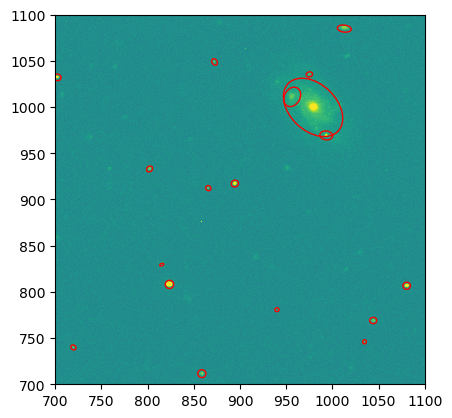

In [232]:
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='viridis',
               vmin=m-s, vmax=m+s, origin='lower')
areas=[]
# plot an ellipse for each object
for i in range(len(objects)):
    areas.append(np.pi*objects['a'][i]*objects['b'][i])
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
print(np.argmax(areas))
#plt.xlim(900,1200)
#plt.ylim(900,1200)
print(obj)
plt.xlim(700,1100)
plt.ylim(700,1100)

In [233]:
kronrad, krflag = sep.kron_radius(data, [x], [y], [a], [b], [theta], 6.0)
flux, fluxerr, flag = sep.sum_ellipse(data, [x], [y], [a], [b], [theta], 2.5*kronrad,
                                      subpix=1,bkgann=(3.5*kronrad,4*kronrad),mask=mask)
flag |= krflag  # combine flags into 'flag'
print(flux)

[203190.93442719]


(700.0, 1100.0)

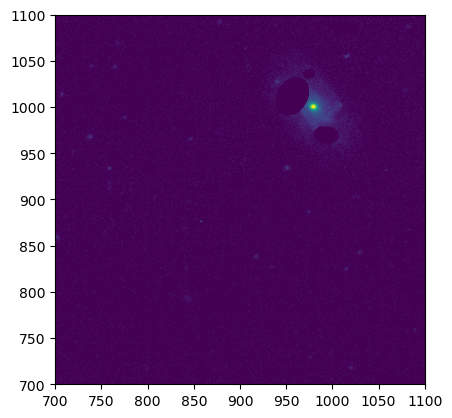

In [234]:
plt.imshow(test,vmin=bkg.globalback,vmax=2*bkg.globalback,cmap='viridis')
plt.xlim(700,1100)
plt.ylim(700,1100)

(700.0, 1100.0)

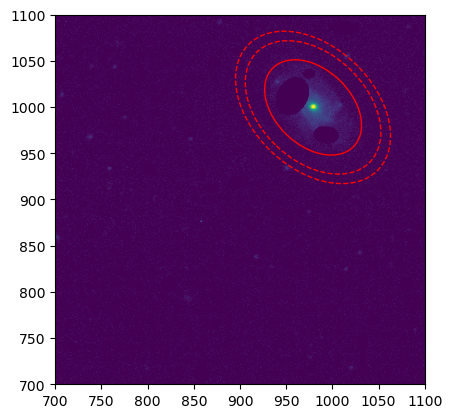

In [235]:
fig, ax = plt.subplots()
ax.imshow(test,vmin=bkg.globalback,vmax=2*bkg.globalback,cmap='viridis')
mask = np.zeros(data.shape, dtype=bool)
e_app = Ellipse(xy=(x, y),
                width=2.5*kronrad*a,
                height=2.5*kronrad*b,
                angle=theta*(180/np.pi))
e_app.set_facecolor('none')
e_app.set_edgecolor('red')
ax.add_artist(e_app)
e_ann_in = Ellipse(xy=(x, y),
                width=3.5*kronrad*a,
                height=3.5*kronrad*b,
                angle=theta*(180/np.pi),
                ls='--')
e_ann_in.set_facecolor('none')
e_ann_in.set_edgecolor('red')
ax.add_artist(e_ann_in)
e_ann_out = Ellipse(xy=(x, y),
                width=4*kronrad*a,
                height=4*kronrad*b,
                angle=theta*(180/np.pi),
                ls='--')
e_ann_out.set_facecolor('none')
e_ann_out.set_edgecolor('red')
ax.add_artist(e_ann_out)
plt.xlim(700,1100)
plt.ylim(700,1100)

In [168]:
print(mask)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
